# Capstone Project Sandbox

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Lot(object):
    def __init__(self):
        self.size = None
        #Coords where lot is. Just for viz
        self.loc = []
        #Simplify model by making land worth $1 per sqft at start
        self.value = self.size
        self.owned_by = None

#    def value_increase(self, by):
        #Start with just inflation
        #self.value *= 1 + by

#Lot.value_increase = value_increase

class Household(object):
    def __init__(self):
        self.lot = None
        #Simplify model by holding can_spend constant
        self.can_spend = 0

def sell():
    pass
    
class Simulation(object):
    def __init__(self, land, num_lots, lot_size_avg, lot_size_std,
                 pop_start, can_spend_avg, can_spend_std,
                 years):
        self.housing_stock = []
        #self.land_log = [land]
        
        #Create population distribution to simulate variety of lot sizes
        #For now house size equals lot size
        lots = np.random.normal(scale = lot_size_std, loc = lot_size_avg, size = num_lots)
        
        #Fill up land area with lots
        while land > 0:
            size = np.round(np.random.choice(lots, replace = False), 0)
            #Create a new household only if the house/lot size will fit on the available land left
            if size > land:
                #Need to break the loop here otherwise it keeps running until a random size is
                #drawn that fits the available remaning land.
                break
            else:
                 #Instantiate a lot with a random size
                lot = Lot()
                lot.size = size
                #Simplify model by making land worth $1/sqft
                lot.value = size
                land -= size
                self.housing_stock.append(lot)

In [270]:
def draw_land_grid(land):
    '''Writes a dict of y values, each with a dict of x values.
    Works as a grid of xes and yes.'''
    root = int(np.round(np.sqrt(land), 0) + 3)
    x_range = root
    y_range = root
    #Each point in the dict will get switched True when a house is drawn on it
    grid = {y: {x: False for x in np.arange(x_range)} for y in np.arange(y_range)}
    return grid

#(Each row is a tuple of (x, bool))
def find_loc(grid, lot, next_x, next_y):
    '''
    #Traverse each row in the land grid via grid dict
    '''
    x_range = len(grid[0])
    y_range = len(grid)
    #One side of the square lot
    frontage = int(np.round(np.sqrt(lot.size), 0))
    #Traverse the y rows in the grid dict
    for y in np.arange(next_y, y_range):
        #If row isn't too full for this lot
        if x_range - sum([x_i for x_i in grid[y]]) > frontage:
        
            print('Looking in row', y)
            #Traverse the row of x values
            for x in np.arange(next_x, x_range):
                print('Looking in x', x)
                #If the right side of the lot is at the right edge of the grid, 
                #and at or below the top, continue
                if ((x + frontage) <= (x_range - 1)) and ((y + frontage) <= (y_range - 1)):
                    #If all frontage points in the proposed lot return False
                    if avail(grid, x, y, frontage):
                        print('Assigning lot here')
                        #House gets assigned these coords
                        assign_loc(lot, x, y)
                        #Coords get changed to True in the grid dict
                        fill_coords(grid, lot.loc)
                        #Break the loop
                        #print('Found lot for ', lot.size)
                        #Return next x and next y to start on
                        return (x + frontage), y
        #If spot isn't found, reset x to 0 before moving up to next y
        next_x = 0
    #else:
        #print(y, (sum([v for k, v in xes.items()]) > (len(xes) * 0.9)))

def assign_loc(lot, x, y):
    '''
    Assign a location to a lot.
    '''
    frontage = int(np.round(np.sqrt(lot.size), 0))
    xes = np.arange(x, x + frontage)
    yes = np.arange(y, y + frontage)
    loc = [(x, y) for y in yes for x in xes]
    lot.loc = loc
    
def fill_coords(grid, loc):
    '''
    Fill the coords in the grid dict after assignment of previous lot.
    '''
    for coord in loc:
        #Reset the point to True in the dict of grid
        grid[coord[1]][coord[0]] = True

In [260]:
def avail(grid, x, y, frontage):
    x_range = np.arange(x, x + frontage)
    y_range = np.arange(y, y + frontage)
    
    #List of bools returned from each point checked
    bottom_points = [grid[y][x_i] for x_i in x_range]
    left_side_points = [grid[y_i][x] for y_i in y_range]
    
    #Value of all bools
    points = sum(bottom_points) + sum(left_side_points)

    #If even one point in the proposed lot is taken (points != 0)
    if points:
        return False
    #If not a single point in the proposed lot is taken (points == 0)
    else:
        print(x, y, 'is avail!')
        return True

In [265]:
#CITY SETTINGS
#Size of land area in sqft (for now)
land = 1000000 #one trillion sqft in SF
num_lots = 1000 #800,000 in SF
lot_size_avg = 2000
lot_size_std = 500

#Starting population
pop_start = 1000
can_spend_avg = 2000
can_spend_std = 500

years = 10

#Probability distribution of house sizes
#house_size_dist = np.random.normal(scale = house_size_std, loc = avg_house_size, size = households)


sim = Simulation(land = land, num_lots = num_lots, lot_size_avg = lot_size_avg, lot_size_std = lot_size_std,
                 pop_start = pop_start, can_spend_avg = can_spend_avg, can_spend_std = can_spend_std,
                 years = years)

In [266]:
#Draw grid for sim
grid = draw_land_grid(land)

In [271]:
counter = 0
next_x = 0
next_y = 0
for lot in sim.housing_stock:
    #Draw a lot on the grid
    next_x, next_y = find_loc(grid, lot, next_x, next_y)
    counter += 1
    print(counter, 'out of', len(sim.housing_stock))

0 0


TypeError: cannot unpack non-iterable NoneType object

0

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


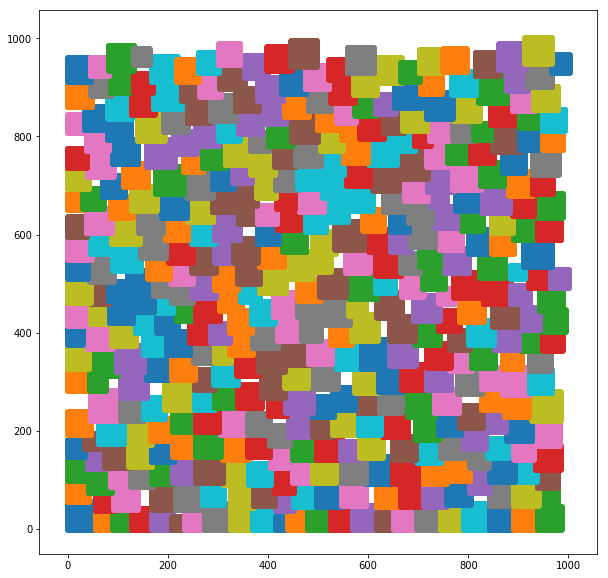

In [188]:

fig = plt.figure(figsize = (10,10))
%time
for lot in sim.housing_stock:
    x = [point[0] for point in lot.loc]
    y = [point[1] for point in lot.loc]
    plt.scatter(x, y, label = lot.size)

plt.show()

In [11]:
total_housing_area = [house.size for house in sim.housing_stock]

In [12]:
sum(total_housing_area)

998189.6217209711

(array([ 4.,  0.,  2.,  0.,  2.,  2.,  0.,  2.,  3.,  3.,  1.,  2.,  7.,
         7.,  5., 10., 13.,  9.,  7., 14.,  8., 31., 31., 20., 18., 34.,
        10., 27., 18., 26., 13., 17., 19., 15., 21., 22., 13.,  9., 13.,
        13., 13.,  3.,  5.,  2.,  1.,  3.,  1.,  1.,  0.,  3.]),
 array([ 422.53871372,  480.04012851,  537.5415433 ,  595.0429581 ,
         652.54437289,  710.04578768,  767.54720247,  825.04861726,
         882.55003205,  940.05144684,  997.55286163, 1055.05427642,
        1112.55569121, 1170.057106  , 1227.5585208 , 1285.05993559,
        1342.56135038, 1400.06276517, 1457.56417996, 1515.06559475,
        1572.56700954, 1630.06842433, 1687.56983912, 1745.07125391,
        1802.5726687 , 1860.0740835 , 1917.57549829, 1975.07691308,
        2032.57832787, 2090.07974266, 2147.58115745, 2205.08257224,
        2262.58398703, 2320.08540182, 2377.58681661, 2435.08823141,
        2492.5896462 , 2550.09106099, 2607.59247578, 2665.09389057,
        2722.59530536, 2780.09672015

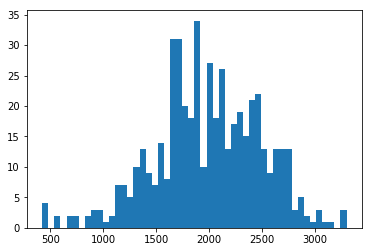

In [13]:
plt.hist(total_housing_area, bins = 50)